This notebook contains:
1. Fixation analysis with respect to different fixation types;
2. Cumulative distribution function plots;
3. Correlational analysis
4. Box-plots of fixation counts and durations.

### 0. Import statements & helper functions ###

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import scipy.stats as stats
import pingouin as pg #ICC

In [2]:
## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a df to include only rows where the timestamp falls within a given intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]


## function_2 to compute descriptive metrics of duration durations of each type

def compute_fixation_durations(fixations_df, fixation_type):
    """
    Computing average, min, and max duration for a given fixation type.
    """
    type_fixations = fixations_df[fixations_df['type'] == fixation_type]
    return type_fixations['duration [ms]'].agg(['mean', 'min', 'max', 'sum', 'median'])


### 1. Main part (loading files and making dataframes) ###

In [3]:
# where all participant folders are located
base_path = "/Users/alina/Downloads/Thesis/raw/"

fixation_analysis = [] # a list to keep general information

all_durations = [] # to keep all durations

participant_cdf_data = defaultdict(lambda: defaultdict(list)) # initiating a nested dictionary (participant + fixation type) to plot CDF for 2 recordings combined

# loading files for each recording based on how they are organised on my computer
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        participant_id = f"P{participant_number}"
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split('_')[-1]
                recording_path = os.path.join(folder_path, recording_folder)

                try:
                    files = {
                        "fixations_on_everything": os.path.join(recording_path, f"fixations_on_everything_{participant_number}_{recording_number}.csv"), #categorised fixations
                        "world_timestamps": os.path.join(recording_path, "world_timestamps.csv"), #timestamps for video frames from Pupil Cloud
                        "detections": os.path.join(recording_path, f"detections_{participant_number}_{recording_number}.csv"), # yolo detections
                        "face_detections": os.path.join(recording_path, "face_detections.csv"), # facemapper detections
                        "events": os.path.join(recording_path, f"events.csv") #events to clean data
                    }
                    data = {name: pd.read_csv(file) for name, file in files.items()}

                    ### filtering all necessery files

                    # using events file to filter the data to only experiment-relevant
                    events_df = data["events"].sort_values("timestamp [ns]")
                    A_events, B_events, C_events, D_events = (events_df[events_df["name"] == event] for event in ['A', 'B', 'C', 'D'])
                    intervals = [
                        (A_events["timestamp [ns]"].max(), B_events["timestamp [ns]"].min()),
                        (B_events["timestamp [ns]"].max(), C_events["timestamp [ns]"].min()),
                        (C_events["timestamp [ns]"].max(), D_events["timestamp [ns]"].min())
                    ]

                    face_detections_df = filter_by_intervals(data["face_detections"], intervals)

                    video_df = pd.DataFrame({
                        "Frame": np.arange(len(data["world_timestamps"])),
                        "timestamp [ns]": data["world_timestamps"]['timestamp [ns]'],
                    })
                    filtered_frames = video_df['Frame']
                    detections_df = data["detections"][data["detections"]['Frame'].isin(filtered_frames)]

                    categorised_fixations_df = filter_by_intervals(data["fixations_on_everything"], intervals)

                    fixation_types = ['face', 'body', 'background']

                    # making a list of all fixation durations for all recordings based on type of fixations (to make a box-plot later)
                    for fixation_type in fixation_types:
                        durations = categorised_fixations_df[categorised_fixations_df['type'] == fixation_type]['duration [ms]']
                        for duration in durations:
                            all_durations.append({
                                                'Participant': participant_id,
                                                'Fixation Type': fixation_type,
                                                'Duration': duration
                                                  })
                            
                    # convert to df
                    durations_df = pd.DataFrame(all_durations)


                    ### steps to plot CDF for each articipant and fixation type later

                    # normalising time for better generazability and combining 2 recordings
                    min_ts = categorised_fixations_df['timestamp [ns]'].min()
                    max_ts = categorised_fixations_df['timestamp [ns]'].max()
                    categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)

                    if participant_id not in participant_cdf_data: # initializes a dictionary for a participant with keys: face, body, background
                        participant_cdf_data[participant_id] = {ft: [] for ft in ['face', 'body', 'background']}

                    # grouping for fixation types
                    for fixation_type, group in categorised_fixations_df.groupby('type'): #grouping fixations by type
                        group = group.sort_values(by='timestamp [ns]')
                        group['cumulative_count'] = range(1, len(group) + 1) # calculate count for each type
                        group['cumulative_probability'] = group['cumulative_count'] / len(group) # CDF
                        
                        # grouping for participant and store CDF data
                        participant_cdf_data[participant_id][fixation_type].append(
                            group[['normalised_time', 'cumulative_probability']].reset_index(drop=True)
                        )


                    ### making a df with all relevant info for each recording for further analysis
                    fixation_counts = {f"{ft} fixations": len(categorised_fixations_df[categorised_fixations_df['type'] == ft]) for ft in fixation_types}
                    total_fixations = sum(fixation_counts.values())
                    duration_stats = {ft: compute_fixation_durations(categorised_fixations_df, ft) for ft in fixation_types}

                    fixation_analysis.append({
                        "Participant": participant_number,
                        "Recording": recording_number,
                        **fixation_counts,
                        "Total fixations": total_fixations,
                        **{f"{ft} {stat} duration (ms)": duration_stats[ft][stat] for ft in fixation_types for stat in ['mean', 'min', 'max', 'sum', 'median']},
                        "Face detections": len(face_detections_df),
                        "Body detections": len(detections_df),
                    })

                # error if some files weren't found/loaded
                except Exception as e:
                    print(f"❌ Error processing P{participant_number}_{recording_number}: {e}")

# a df with variables describing fixations per recording
fixation_analysis_df = pd.DataFrame(fixation_analysis)

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_14388/3052774376.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_14388/3052774376.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)


❌ Error processing P14_2: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 14/P14_2/fixations_on_everything_14_2.csv'
❌ Error processing P14_1: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 14/P14_1/fixations_on_everything_14_1.csv'


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_14388/3052774376.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_14388/3052774376.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/r

❌ Error processing P18_1: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 18/P18_1/fixations_on_everything_18_1.csv'
❌ Error processing P18_2: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 18/P18_2/fixations_on_everything_18_2.csv'


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_14388/3052774376.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)


In [4]:
save_path = os.path.join(base_path, 'Fixations_stats_all_recordings.csv')
fixation_analysis_df.to_csv(save_path, index=False) 

fixation_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Participant                      12 non-null     object 
 1   Recording                        12 non-null     object 
 2   face fixations                   12 non-null     int64  
 3   body fixations                   12 non-null     int64  
 4   background fixations             12 non-null     int64  
 5   Total fixations                  12 non-null     int64  
 6   face mean duration (ms)          12 non-null     float64
 7   face min duration (ms)           12 non-null     float64
 8   face max duration (ms)           12 non-null     float64
 9   face sum duration (ms)           12 non-null     float64
 10  face median duration (ms)        12 non-null     float64
 11  body mean duration (ms)          12 non-null     float64
 12  body min duration (ms)  

In [5]:
categorised_fixations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6851 entries, 465 to 7327
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp [ns]   6851 non-null   int64  
 1   type             6851 non-null   object 
 2   fixation id      6851 non-null   int64  
 3   duration [ms]    6851 non-null   float64
 4   normalised_time  6851 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 321.1+ KB


In [6]:
# making a df with one row per participant (combining recordings)

#duration_metrics = ['mean', 'min', 'max', 'sum', 'median'] #prob don't need

agg_dict = {
    **{f"{ft} fixations": "sum" for ft in fixation_types},
    "Total fixations": "sum",
    "Face detections": "sum",
    "Body detections": "sum"
}
# fix this if i do correlation per participant
""" **{
        f"{ft} {stat} duration (ms)": "mean"  
        for ft in fixation_types
        for stat in duration_metrics
    }} """

participant_fixations_summary = fixation_analysis_df.groupby("Participant").agg(agg_dict).reset_index()

### Consistance of Fixation Counts within a participant 

In [7]:
# proportion of each fixation type
fixation_analysis_df['proportion face'] = fixation_analysis_df['face fixations'] / fixation_analysis_df['Total fixations']
fixation_analysis_df['proportion body'] = fixation_analysis_df['body fixations'] / fixation_analysis_df['Total fixations']
fixation_analysis_df['proportion background'] = fixation_analysis_df['background fixations'] / fixation_analysis_df['Total fixations']

In [33]:
fixation_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Participant                      12 non-null     object 
 1   Recording                        12 non-null     object 
 2   face fixations                   12 non-null     int64  
 3   body fixations                   12 non-null     int64  
 4   background fixations             12 non-null     int64  
 5   Total fixations                  12 non-null     int64  
 6   face mean duration (ms)          12 non-null     float64
 7   face min duration (ms)           12 non-null     float64
 8   face max duration (ms)           12 non-null     float64
 9   face sum duration (ms)           12 non-null     float64
 10  face median duration (ms)        12 non-null     float64
 11  body mean duration (ms)          12 non-null     float64
 12  body min duration (ms)  

In [13]:
### Intraclass Correlation Coefficient

#0.75–0.90 = Good reliability

#0.50–0.75 = Moderate reliability

types = ['face', 'body', 'background']

for type in types:

    df_temp = fixation_analysis_df[['Participant', 'Recording', f'proportion {type}']].rename(
        columns={f'proportion {type}': 'proportion'}
    )
    
    # ICC
    icc = pg.intraclass_corr(data=df_temp,
                             targets='Participant',
                             raters='Recording',
                             ratings='proportion')
    
    # show only ICC(3,1)
    icc3 = icc[icc['Type'] == 'ICC3']
    
    print(f"\nICC(3,1) for {type} fixations proportion:")
    print(icc3[['ICC', 'CI95%']])


ICC(3,1) for face fixations proportion:
        ICC         CI95%
2  0.773682  [0.05, 0.96]

ICC(3,1) for body fixations proportion:
        ICC          CI95%
2  0.692322  [-0.13, 0.95]

ICC(3,1) for background fixations proportion:
        ICC          CI95%
2  0.745289  [-0.02, 0.96]


Negative or near-zero lower CI bounds => the result isn’t stable 

In [19]:
### differences between proportion of fixation of each type per participant 

fixation_analysis_df['face_fix_per_detection'] = fixation_analysis_df['face fixations'] / fixation_analysis_df['Face detections']
fixation_analysis_df['body_fix_per_detection'] = fixation_analysis_df['body fixations'] / fixation_analysis_df['Body detections']

participants = fixation_analysis_df['Participant'].unique()
consistency = []

for p in participants:
    sub = fixation_analysis_df[fixation_analysis_df['Participant'] == p].sort_values('Recording')
    if len(sub) == 2:
        s1, s2 = sub.iloc[0], sub.iloc[1]
        
        # proportion differences between 2 recordings of each participant
        face_diff = abs(s1['proportion face'] - s2['proportion face'])
        body_diff = abs(s1['proportion body'] - s2['proportion body'])
        bg_diff = abs(s1['proportion background'] - s2['proportion background'])
        
        face_det_ctrl_diff = abs(s1['face_fix_per_detection'] - s2['face_fix_per_detection'])
        body_det_ctrl_diff = abs(s1['body_fix_per_detection'] - s2['body_fix_per_detection'])

        consistency.append({
            'Participant': p,
            'face_prop_diff': face_diff,
            'body_prop_diff': body_diff,
            'bg_prop_diff': bg_diff,
            'face_prop_detection_diff': face_det_ctrl_diff,
            'body_prop_detection_diff': body_det_ctrl_diff
        })

consistency_df = pd.DataFrame(consistency)
consistency_df


,Participant,face_prop_diff,body_prop_diff,bg_prop_diff,face_prop_detection_diff,body_prop_detection_diff
0,09,0.011430,0.062593,0.051163,0.000601,0.000376
1,12,0.014139,0.004566,0.009574,0.001114,0.000373
2,15,0.003636,0.085821,0.089457,0.000004,0.000495
3,10,0.002414,0.055187,0.057601,0.000077,0.000023
4,16,0.007140,0.012601,0.019741,0.000479,0.000179
5,11,0.000544,0.069159,0.068614,0.000103,0.000628


Differences are much smaller when proportion is from detections and not total fixations.

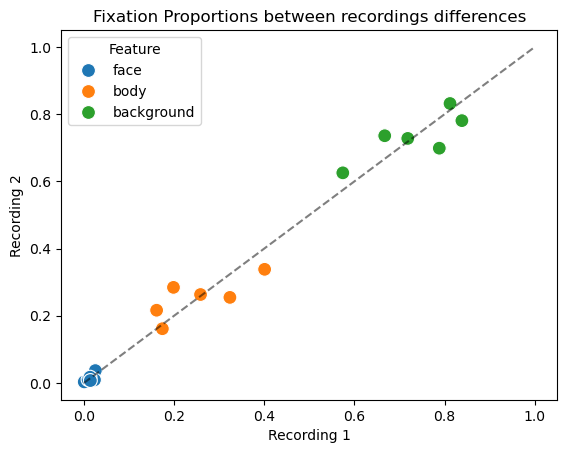

In [12]:
## plot and print of residuals (differences) of each fixation type proportion

types = ["face", "body", "background"]

differences = []

for participant, group in fixation_analysis_df.groupby("Participant"):
    if len(group) == 2:
        for type in types:
            # get values for the two recordings
            vals = group[f"proportion {type}"].values
            
            differences.append({
                "Participant": participant,
                "Feature": type,
                "Recording 1": vals[0],
                "Recording 2": vals[1],
                "Absolute Difference": abs(vals[0] - vals[1])
            })

types_diff_df = pd.DataFrame(differences)
#print(types_diff_df)

sns.scatterplot(
    data=types_diff_df,
    x="Recording 1",
    y="Recording 2",
    hue="Feature",
    #style="Participant",
    s=100
)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # line if there were no differences
plt.title("Fixation Proportions between recordings differences")
plt.xlabel("Recording 1")
plt.ylabel("Recording 2")
plt.show()


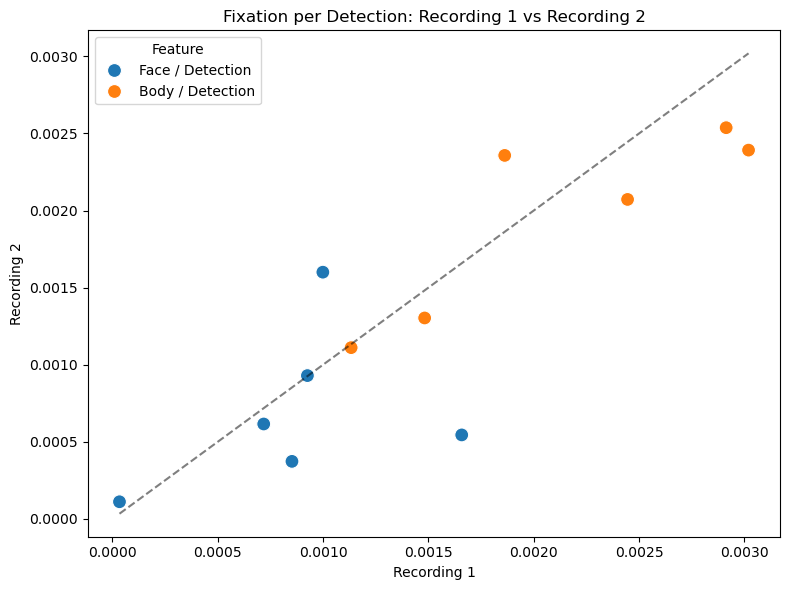

In [21]:

types = ["face", "body"]

differences = []

for participant, group in fixation_analysis_df.groupby("Participant"):
    if len(group) == 2:
        for type in types:
            col = f"{type}_fix_per_detection"
            vals = group[col].values
            
            differences.append({
                "Participant": participant,
                "Feature": f"{type.capitalize()} / Detection",
                "Recording 1": vals[0],
                "Recording 2": vals[1],
                "Absolute Difference": abs(vals[0] - vals[1])
            })

det_controlled_df = pd.DataFrame(differences)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=det_controlled_df,
    x="Recording 1",
    y="Recording 2",
    hue="Feature",
    s=100
)

# Diagonal line (perfect match line)
min_val = min(det_controlled_df["Recording 1"].min(), det_controlled_df["Recording 2"].min())
max_val = max(det_controlled_df["Recording 1"].max(), det_controlled_df["Recording 2"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

plt.title("Fixation per Detection: Recording 1 vs Recording 2")
plt.xlabel("Recording 1")
plt.ylabel("Recording 2")
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.formula.api import ols

OLS_df = fixation_analysis_df.rename(columns={
    "face fixations": "face_fixations",
    "Face detections": "face_detections",
    "Total fixations": "total_fixations"
})

#OLS_df["face_fixation_prop"] = (
    #OLS_df["face_fixations"] / OLS_df["total_fixations"]
#)

# Run the model with clean names
model = ols(
    formula="face_fixations ~ face_detections *  C(Recording) + total_fixations ",
    data=OLS_df
).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:         face_fixations   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     4.267
Date:                Thu, 29 May 2025   Prob (F-statistic):             0.0462
Time:                        14:56:15   Log-Likelihood:                -58.702
No. Observations:                  12   AIC:                             127.4
Df Residuals:                       7   BIC:                             129.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/alina/opt/anaconda3/envs/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


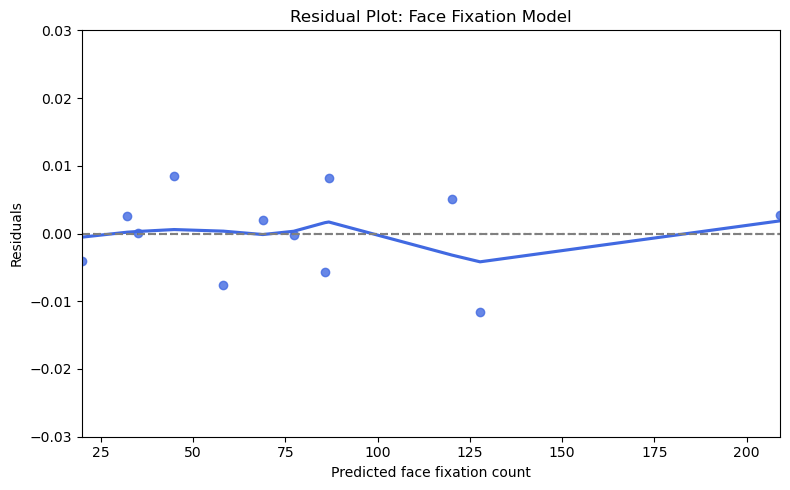

In [56]:

OLS_df["predicted"] = model.fittedvalues
OLS_df["residuals"] = model.resid

# Residuals plot
plt.figure(figsize=(8, 5))
sns.residplot(x="predicted", y="face_fixation_prop", data=OLS_df, lowess=True, color="royalblue")
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicted face fixation count")
plt.ylim(-0.03, 0.03)
plt.ylabel("Residuals")
plt.title("Residual Plot: Face Fixation Model")
plt.tight_layout()
plt.show()


### other 

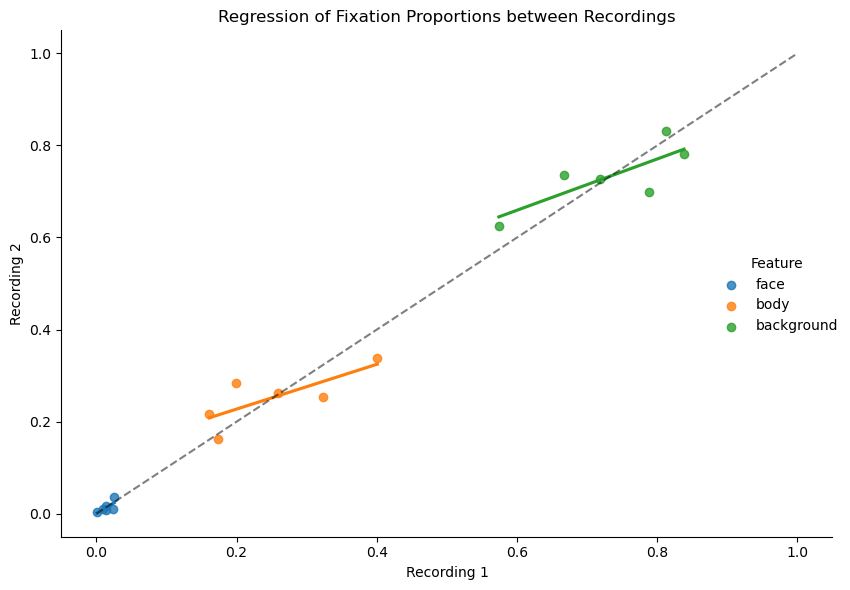

In [19]:
# plot with regression lines
sns.lmplot(
    data=types_diff_df,
    x="Recording 1",
    y="Recording 2",
    hue="Feature",
    #markers=["o", "s", "D"],
    ci=None,
    height=6,
    aspect=1.2
)

# Identity line (perfect agreement)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("Regression of Fixation Proportions between Recordings")
plt.xlabel("Recording 1")
plt.ylabel("Recording 2")
plt.tight_layout()
plt.show()


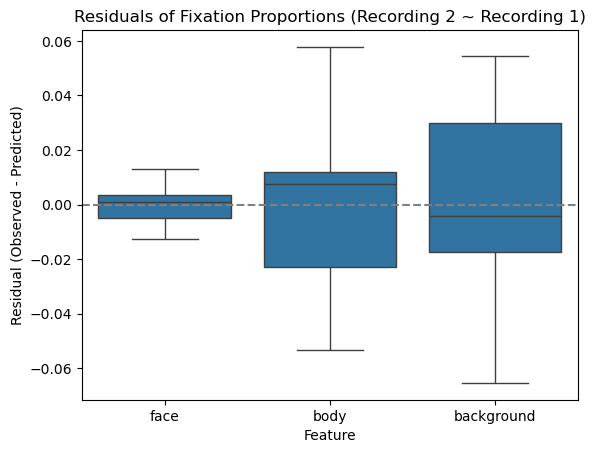

In [106]:
import statsmodels.api as sm

residuals = []

for feature in features:
    # Subset data for the feature
    df_feat = feature_diff_df[feature_diff_df["Feature"] == feature]
    
    # Fit simple linear regression: Recording 2 ~ Recording 1
    X = sm.add_constant(df_feat["Recording 1"])
    y = df_feat["Recording 2"]
    model = sm.OLS(y, X).fit()
    
    # Calculate residuals and add to the dataframe
    df_feat = df_feat.copy()
    df_feat["Residual"] = model.resid
    residuals.append(df_feat)

# Combine into one dataframe
residual_df = pd.concat(residuals)

# Optional: plot residuals
sns.boxplot(data=residual_df, x="Feature", y="Residual")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals of Fixation Proportions (Recording 2 ~ Recording 1)")
plt.ylabel("Residual (Observed - Predicted)")
plt.show()


### Plots ###

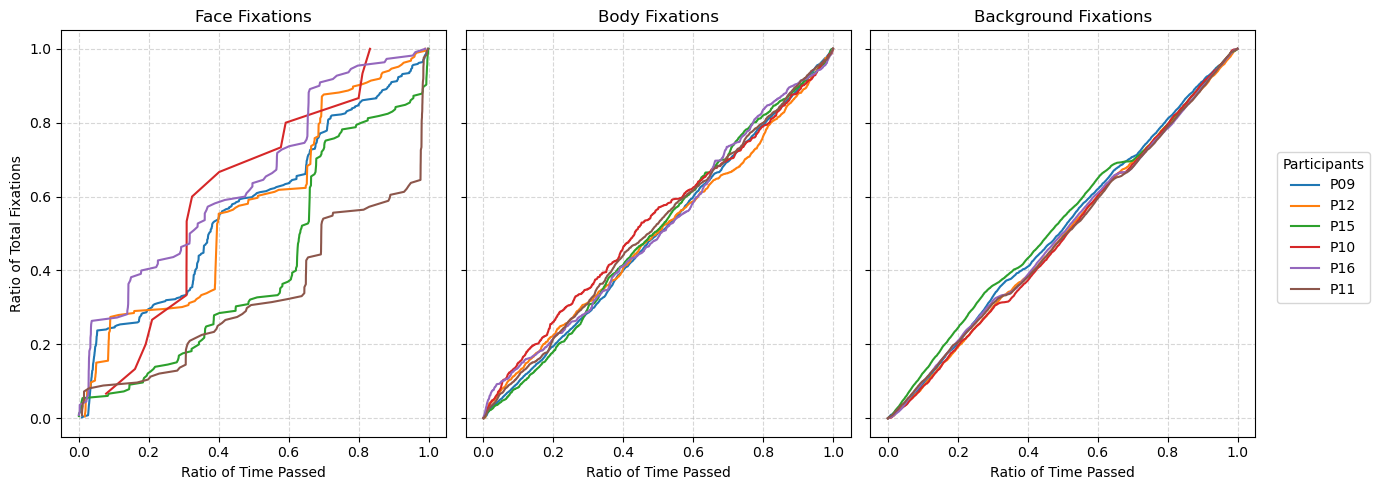

In [6]:
# combine and compute merged CDFs per participant
merged_participant_cdf = defaultdict(dict)

for participant_id, fixation_types in participant_cdf_data.items():
    for fixation_type, dfs in fixation_types.items():
        combined_df = pd.concat(dfs, ignore_index=True).sort_values(by='normalised_time').reset_index(drop=True)
        combined_df['cumulative_count'] = range(1, len(combined_df) + 1)
        combined_df['cumulative_probability'] = combined_df['cumulative_count'] / len(combined_df)
        merged_participant_cdf[fixation_type][participant_id] = combined_df[['normalised_time', 'cumulative_probability']]

# to plot all fixation types side by side
fixation_types = list(merged_participant_cdf.keys())

fig, axes = plt.subplots(1, len(fixation_types), figsize=(5 * len(fixation_types), 5), sharey=True)

for ax, fixation_type in zip(axes, fixation_types):
    participant_dfs = merged_participant_cdf[fixation_type]
    for participant_id, df in participant_dfs.items():
        ax.plot(df['normalised_time'], df['cumulative_probability'], label=f'{participant_id}')
    ax.set_title(f'{fixation_type.capitalize()} Fixations')
    ax.set_xlabel('Ratio of Time Passed')
    ax.grid(True, linestyle='--', alpha=0.5)

axes[0].set_ylabel('Ratio of Total Fixations')

# a legend on the right outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Participants', bbox_to_anchor=(0.85, 0.7), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # better visually
plt.show()


In [11]:
# Sum fixations across all participants
total_face = participant_fixations_summary['face fixations'].sum()
total_body = participant_fixations_summary['body fixations'].sum()
total_background = participant_fixations_summary['background fixations'].sum()

# Calculate total fixations
total_fixations = total_face + total_body + total_background

# Calculate percentages
face_pct = total_face * 100 / total_fixations
body_pct = total_body * 100 / total_fixations
background_pct = total_background * 100 / total_fixations

print(f"Total percentage of face fixations for all participant is {face_pct}.")
print(f"Total percentage of body fixations for all participant is {body_pct}.")
print(f"Total percentage of background fixations for all participant is {background_pct}.")

'''# Create the pie chart
labels = ['Face', 'Body', 'Background']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
percentages = [face_pct, body_pct, background_pct]

plt.figure(figsize=(5, 5))
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Overall Fixation Distribution (All Participants)')
plt.axis('equal')
plt.show()'''


Total percentage of face fixations for all participant is 1.4733021184437294.
Total percentage of body fixations for all participant is 25.72788140375494.
Total percentage of background fixations for all participant is 72.79881647780134.


"# Create the pie chart\nlabels = ['Face', 'Body', 'Background']\ncolors = ['#1f77b4', '#ff7f0e', '#2ca02c']\npercentages = [face_pct, body_pct, background_pct]\n\nplt.figure(figsize=(5, 5))\nplt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)\nplt.title('Overall Fixation Distribution (All Participants)')\nplt.axis('equal')\nplt.show()"

### Descriptive and Correlative stats ###

I first calculate the fixation count on each facial landmark and mean duration and then merge this dataframe with the face landmarks count dataframe. 

In [15]:
# loading a file with all fixations for all participants on facial landmarks
landmarks_df = pd.read_csv("/Users/alina/Downloads/Thesis/raw/face_landmarks_all_participants.csv")

# making sure Participant columns are strings (also needed for replacement& so they are same)
landmarks_df['Participant'] = landmarks_df['Participant'].astype(str)
fixation_analysis_df['Participant'] = fixation_analysis_df['Participant'].astype(str)

# Replace participant number '9' with '09' - to merge later
landmarks_df['Participant'] = landmarks_df['Participant'].replace("9", "09")

# same with recording column
landmarks_df['Recording'] = landmarks_df['Recording'].astype(str)
fixation_analysis_df['Recording'] = fixation_analysis_df['Recording'].astype(str)

# calculating mean duration for each AOI (Eyes, Nose, Mouth)
mean_duration_facial_landmarks = landmarks_df[landmarks_df['assigned_aoi'].isin(['left_eye', 'mouth', 'nose', 'right_eye'])] \
    .groupby(['Participant', 'Recording', 'assigned_aoi'])['duration (ms)'].mean().reset_index()

# mean durations per AOI df (to use it in correlation analysis)
mean_duration_facial_landmarks_df = mean_duration_facial_landmarks.pivot_table( #
    index=['Participant', 'Recording'],
    columns='assigned_aoi',
    values='duration (ms)',
    aggfunc='mean'
).reset_index()

# renaming columns to include "mean duration" as the prefix and excluding 'Participant' and 'Recording'
mean_duration_facial_landmarks_df = mean_duration_facial_landmarks_df.rename(columns=lambda x: f"mean duration {x}" if isinstance(x, str) and x not in ['Participant', 'Recording'] else x)

# merge the mean face AOIS durations with the general fixation variables df
combined_df = fixation_analysis_df.merge(mean_duration_facial_landmarks_df, on=['Participant', 'Recording'], how='left')

# creating face AOI fixation counts df
aoi_counts = landmarks_df.pivot_table(
    index=['Participant', 'Recording'],
    columns='assigned_aoi',
    values='fixation_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# merge face AOI counts df with the combined_df
combined_df = combined_df.merge(aoi_counts, on=['Participant', 'Recording'], how='left')

In [38]:
#combined_df.info()
#combined_df.describe().round(2)

#aoi_counts
#mean_duration_facial_landmarks_df

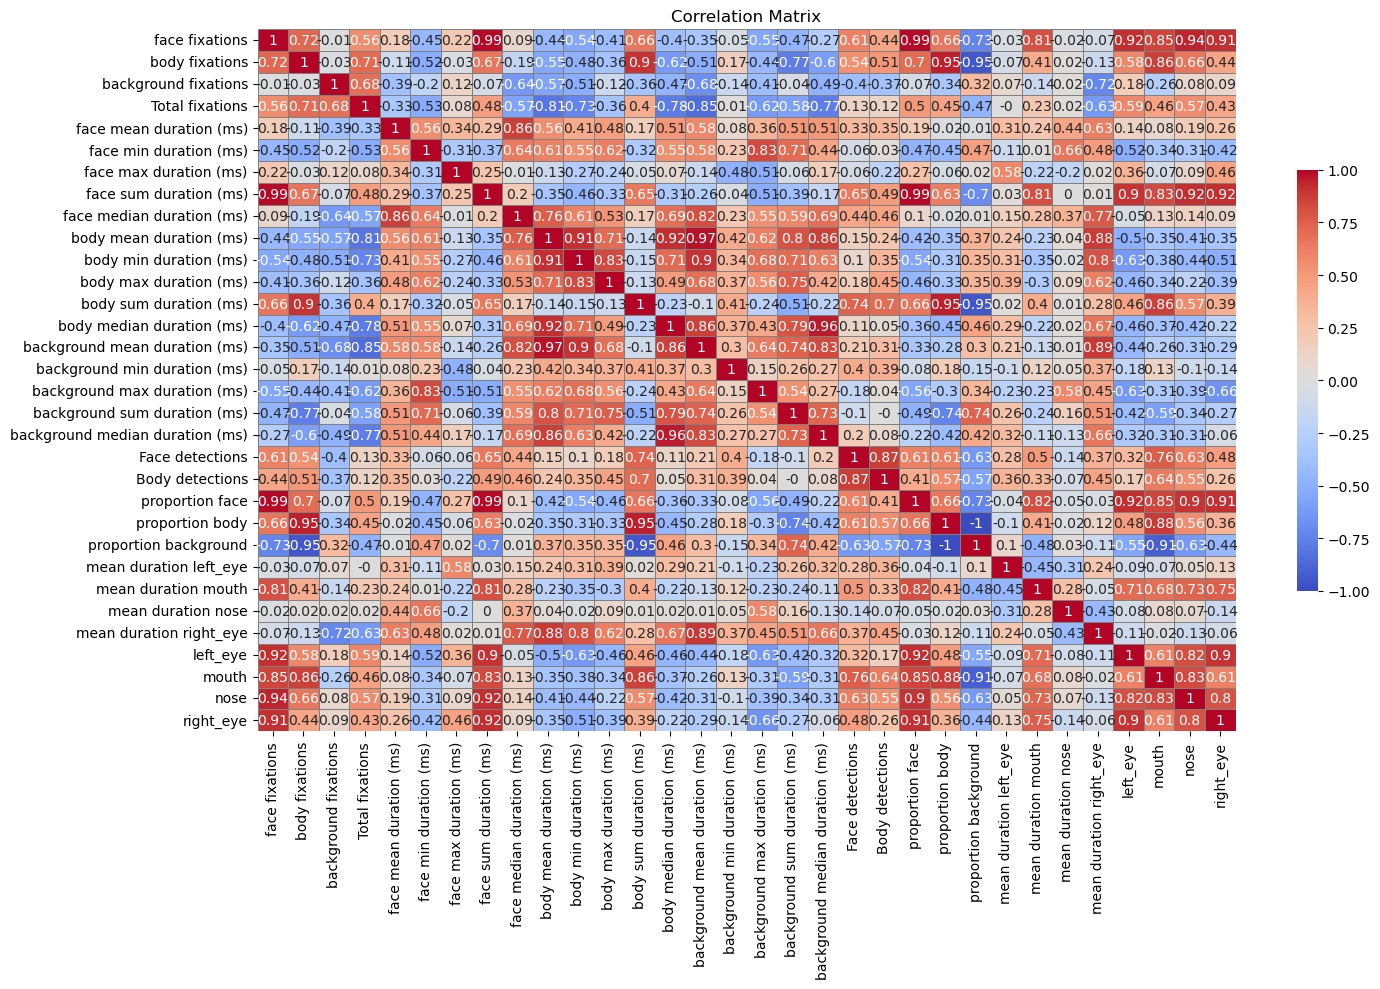

In [16]:
cols_to_exclude = ['Participant', 'Recording']

# a new df excluding those columns for correlations
df_corr = combined_df.drop(columns=cols_to_exclude)
corr_matrix = df_corr.corr().round(2)

plt.figure(figsize=(15, 10))

sns.heatmap(
    corr_matrix ,               
    annot=True,           
    cmap='coolwarm',          
    vmin=-1, vmax=1,             
    center=0,                    
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.6}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

1. Duration metrics strongly correlate between different object categories.
2. Number of face and body detections moderately correlate with the number of face and body detections.
3. Face and body fixation number strongly correlate 
4. As well face and body detection number (which shows that the algorithms work).
5. Mouth correlates with body fixations
other add

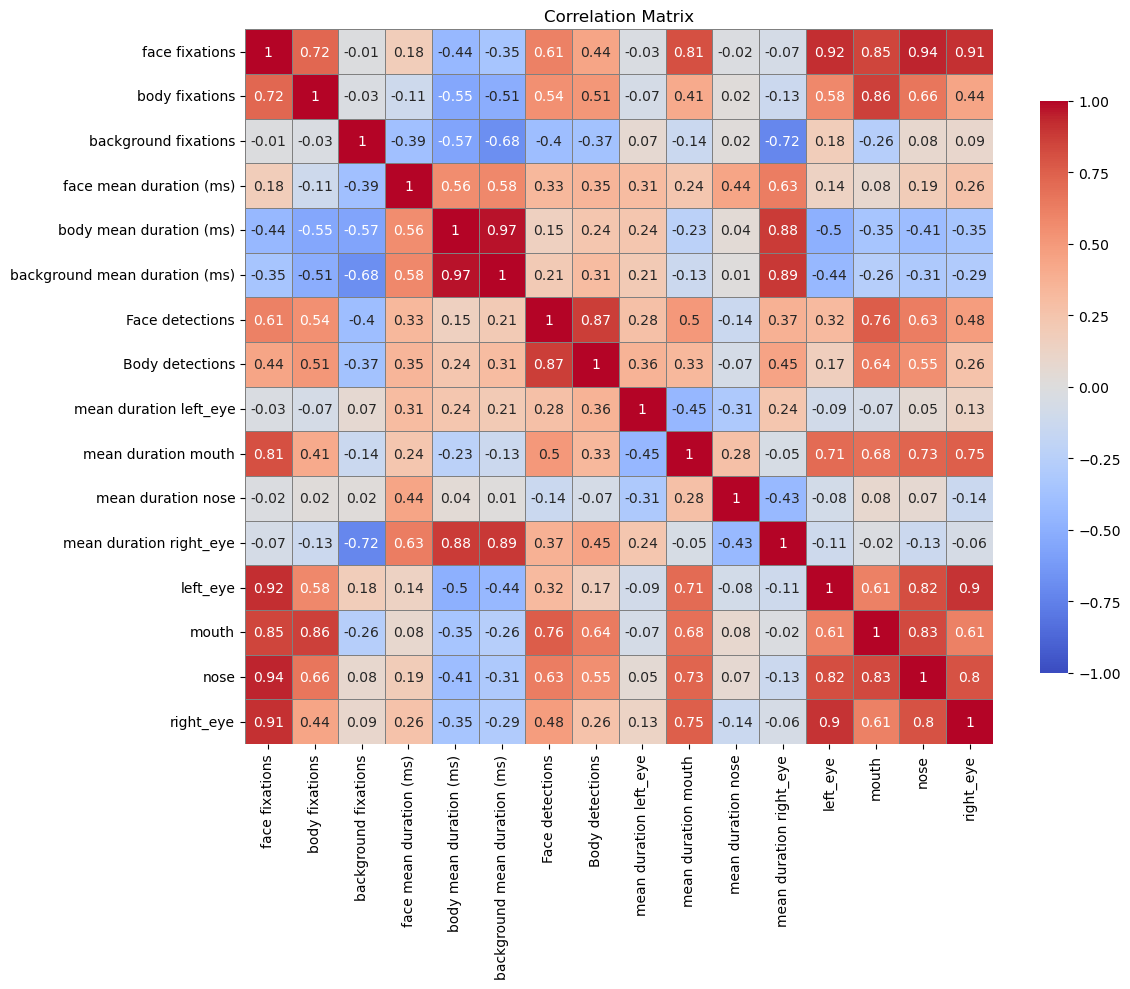

In [ ]:
## only important variables matrix

cols_to_exclude = ['Participant', 'Recording', 'Total fixations', 
                   'body sum duration (ms)', 'face sum duration (ms)', 'background sum duration (ms)',
                   'body min duration (ms)', 'face min duration (ms)', 'background min duration (ms)',
                   'body max duration (ms)', 'face max duration (ms)', 'background max duration (ms)',
                   'body median duration (ms)', 'face median duration (ms)', 'background median duration (ms)' ]

# a new df excluding those columns for correlations
df_corr_small = combined_df.drop(columns=cols_to_exclude)
corr_matrix = df_corr_small.corr(method='pearson').round(2) #note correlation type

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix ,               
    annot=True,            
    cmap='coolwarm',       
    vmin=-1, vmax=1,            
    center=0,                    
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#participant_fixations_summary.info()
#participant_fixations_summary.describe().round()

In [ ]:
# I can also do the same correlations for the participants and not recordings

### PLots - fixation counts and durations ###

In [80]:
## fixation counts mean and standard deviation per category for all participants

# making a df with descriptive statistics
describe_stats = participant_fixations_summary.describe()

# getting mean and st deviation from that df
mean_face_fix_amount = describe_stats.loc['mean', 'face fixations']
mean_body_fix_amount = describe_stats.loc['mean', 'body fixations']
mean_background_fix_amount = describe_stats.loc['mean', 'background fixations']

std_face = describe_stats.loc['std', 'face fixations']
std_body_fix_amount = describe_stats.loc['std', 'body fixations']
std_background_fix_amount = describe_stats.loc['std', 'background fixations']

# new df with the necessery columns
summary_df = pd.DataFrame({
    'Category': ['Face', 'Body', 'Background'],
    'Mean': [mean_face_fix_amount, mean_body_fix_amount, mean_background_fix_amount],
    'Std Dev': [std_face, std_body_fix_amount, std_background_fix_amount],
})
summary_df = summary_df.round(2)
display(summary_df)

,Category,Mean,Std Dev
0,Face,161.00,116.58
1,Body,2811.50,1077.91
2,Background,7955.33,828.68


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49345/866279566.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49345/866279566.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


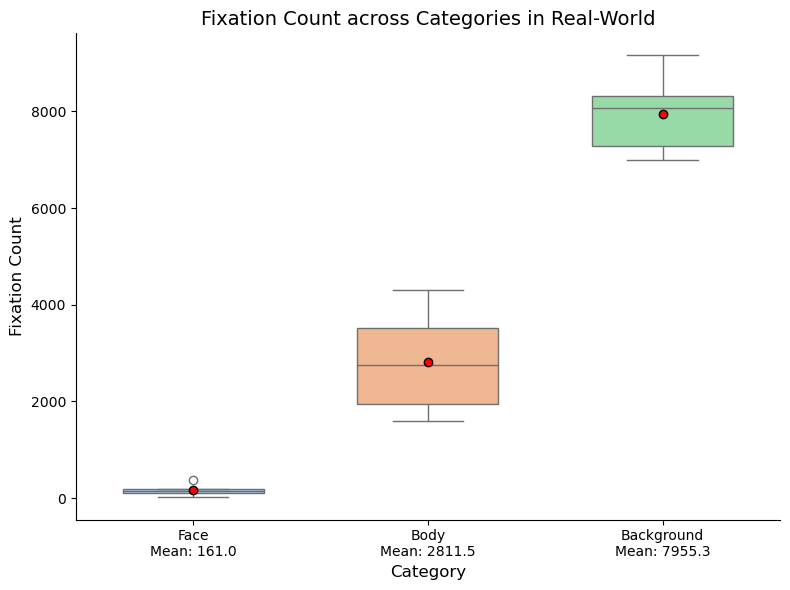

In [81]:
### Fixation count per category box plot

# getting fixation count columns and participant number
fixation_cols = ['face fixations', 'body fixations', 'background fixations']
fixation_data = participant_fixations_summary[['Participant'] + fixation_cols]

# reshaping df to a long format
fixation_melted = fixation_data.melt(id_vars='Participant',
                                     value_vars=fixation_cols,
                                     var_name='Category',
                                     value_name='Fixation Count')

# making category names
fixation_melted['Category'] = fixation_melted['Category'].str.replace(' fixations', '').str.capitalize()

# defining order of categories based on fixation_cols
category_order = [col.replace(' fixations', '').capitalize() for col in fixation_cols]

# calculating means
group_means = fixation_melted.groupby('Category')['Fixation Count'].mean()

# making labels with category + mean
new_labels = [f"{cat}\nMean: {group_means[cat]:.1f}" for cat in category_order]

# box-plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=fixation_melted,
    x='Category',
    y='Fixation Count',
    order=category_order,               
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# x-axis tick labels with category + mean
ax.set_xticklabels(new_labels)

ax.set_title("Fixation Count across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Count", fontsize=12)
ax.set_xlabel("Category", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [82]:
#### Fixation durations median + median absolute value for all recordings per category

# calculating medians from the df with all durations
group_medians = durations_df.groupby("Fixation Type")["Duration"].median().round(2)

# calculating MAD using predifined function
group_mad = durations_df.groupby("Fixation Type")["Duration"].apply(median_abs_deviation).round(2)

duration_stats = pd.DataFrame({
    'Median': group_medians,
    'MAD': group_mad
})
display(duration_stats)

,Median,MAD
Fixation Type,,
background,225.25,75.12
body,225.00,80.00
face,235.25,90.12


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49345/3731808631.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49345/3731808631.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=11)


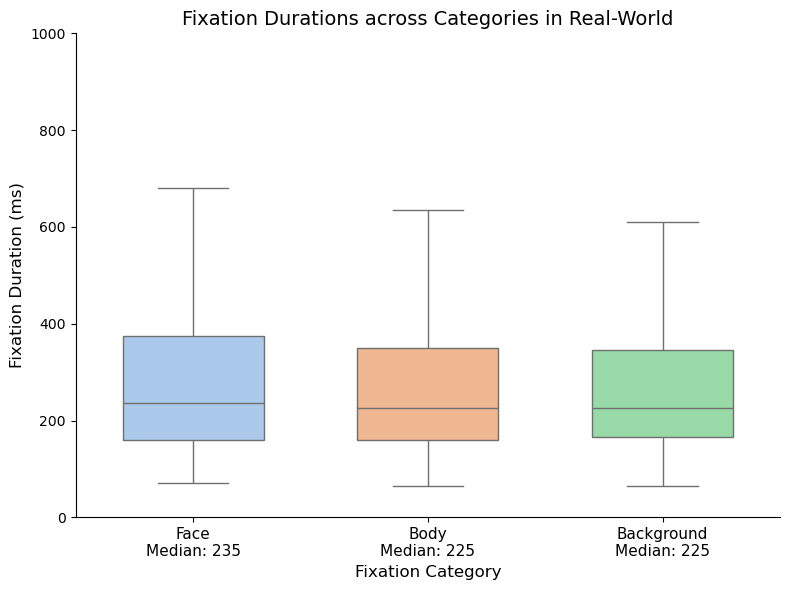

In [83]:
### Fixation durations per category box plot

category_order = ['face', 'body', 'background'] # so it matches

# adding median labels
new_labels = [f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}" for cat in category_order]

# if i want to add MAD to the label
#new_labels = [
    #f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}\nMAD: {group_mad[cat]:.1f}"
    #for cat in category_order]

# box-plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=durations_df,
    x="Fixation Type",
    y="Duration",
    order=category_order,
    palette="pastel",
    showmeans=False, # not visualizing mean
    showfliers=False,  # grey outlier circles
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

ax.set_xticklabels(new_labels, fontsize=11)
ax.set_title("Fixation Durations across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Duration (ms)", fontsize=12)
ax.set_ylim(0,1000)  # setting y-axis limits 
ax.set_xlabel("Fixation Category", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()